<a href="https://colab.research.google.com/github/Mahrokh-Eb/Machine-Learning-With-Python/blob/master/feb2022/3_linearClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## link too google drive -lecture-7


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/numpy/cifar-10-batches-py

Mounted at /content/drive
/content/drive/MyDrive/numpy/cifar-10-batches-py


In [2]:
#!pip install google-colab

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import layers

## loading ccifar 10

In [4]:
import os
import pickle

def load_cifar10_batch(filename):
    """ Load a single batch from CIFAR10 """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('float')
        Y = np.array(Y)
        return X, Y
    
def load_cifar10(dir):
    """ Load all batches of CIFAR10 """
    # load train batch file
    xs = []
    ys = []
    
    for i in range(1, 6):
        filename = os.path.join(dir, 'data_batch_%d' % i)
        X, Y = load_cifar10_batch(filename)
        xs.append(X)
        ys.append(Y)
        
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    
    # load test batch
    Xte, Yte = load_cifar10_batch(os.path.join(dir, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


In [5]:
X_train, y_train, X_test, y_test = load_cifar10('/content/drive/MyDrive/numpy/cifar-10-batches-py')

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


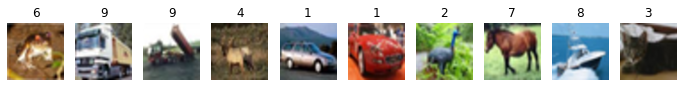

In [7]:
plt.figure(figsize=(12, 2))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i].astype('uint8'), interpolation='spline16')
    plt.title('%d' % y_train[i])
    plt.axis('off')

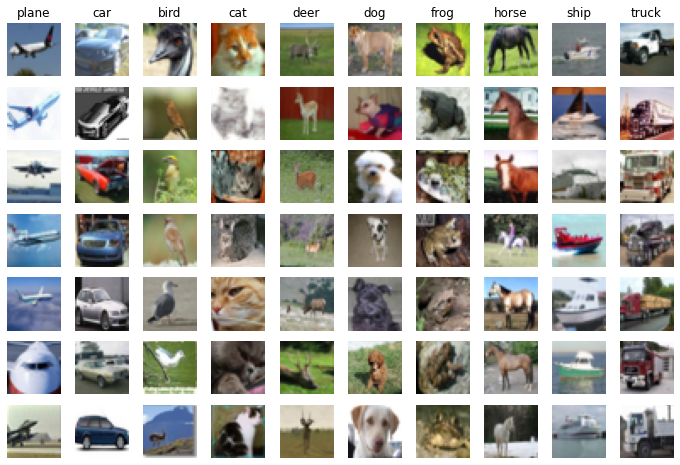

In [8]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

plt.figure(figsize=(12, 8))

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### spliting cifar10 data

In [9]:
# spliting data iinto train, val and test

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# validation data
mask = range(num_training, num_training+num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# training data
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Development data
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# test data
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape:        ', X_train.shape)
print('Train labels shape:      ', y_train.shape)
print('Validation data shape:   ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape:         ', X_test.shape)
print('Test labels shape:       ', y_test.shape)

Train data shape:         (49000, 32, 32, 3)
Train labels shape:       (49000,)
Validation data shape:    (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:          (1000, 32, 32, 3)
Test labels shape:        (1000,)


### preprocessing 

In [10]:
# reshaping from 4D to 2D
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape:   ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape:       ', X_test.shape)
print('dev data shape:        ', X_dev.shape)

Training data shape:    (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:        (1000, 3072)
dev data shape:         (500, 3072)


In [11]:
# deducting mean from each photo
mean_image = np.mean(X_train, axis=0)
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val   -= mean_image
X_test  -= mean_image
X_dev   -= mean_image

### Defining Forward Step

In [12]:
def affine_forward(x, W, b):

  x2d = np.reshape(x, (x.shape[0],-1))
  out = np.dot(x2d, W) + b
  cashe = x, W, b
  return out, cashe

### SVM

In [13]:
def L_i(x, y, W):

    scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
    correct_class_score = scores[y]
    C = W.shape[0] # number of classes, e.g. 10
    
    loss_i = 0.0
    for j in range(C): # iterate over all wrong classes
        if j == y:
            # skip for the true class to only loop over incorrect classes
            continue
        # accumulate loss for the i-th example
        loss_i += max(0, scores[j] - correct_class_score + 1.0)
        
    return loss_i

### create W, b
### Sanity check

In [14]:
# creating W and b
N = X_train.shape[0]
D = np.prod(X_train.shape[1:]) # number of features
C = 10                        

W = 0.0001 * np.random.randn(D, C)
b = np.zeros((C,))

# Sanity check
from layers import affine_forward, svm_loss
scores, _ = affine_forward(X_train, W, b)
loss, _ = svm_loss(scores, y_train, W, reg= 0.0)

In [15]:
from layers import affine_forward, svm_loss_naive

scores, _ = affine_forward(X_train, W, b)
loss, _ = svm_loss_naive(scores, y_train, W, reg=0.0)

print("Data loss = %.2f" % loss)
print('loss')

Data loss = 9.83
loss


# LECTURE 8